# Simulation-based model interpretation with gReLU

This tutorial demonstrates some of gReLU's functions for making predictions on simulated genomic sequences with specific properties. This allows us to decipher the regulatory grammar and syntax learned by a model.

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats

from plotnine import *
import seaborn as sns

%matplotlib inline
os.environ["WANDB_SILENT"] = "true"

## Part 1: CATlas ATAC-seq binary classification model

First we demonstrate some simple functions using the CATLAS binary classification model. We begin by loading the model from the model zoo:

In [2]:
import grelu.resources

catlas = grelu.resources.load_model(
    project="human-atac-catlas",
    model_name="model",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
/opt/conda/lib/python3.11/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case wher

This object contains the model metadata, so we can extract a dataframe describing the cell types for which the model makes predictions.

In [3]:
tasks = pd.DataFrame(catlas.data_params['tasks'])
print(len(tasks))
tasks.head(3)

204


,name,cell type
0,Follicular,Follicular
1,Fibro General,Fibro General
2,Acinar,Acinar


We can also extract genomic intervals that were in the test set of this model:

In [4]:
test_intervals = pd.DataFrame(catlas.data_params['test']['intervals'])
test_intervals.head()

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module,width,cre_idx,enformer_split,split
0,chr1,143497510,143497710,Promoter Proximal,no,yes,113,400,53530,test,test
1,chr1,143498052,143498252,Promoter Proximal,no,yes,4,400,53531,test,test
2,chr1,143498633,143498833,Promoter,yes,no,46,400,53532,test,test
3,chr1,143563536,143563736,Distal,yes,no,63,400,53533,test,test
4,chr1,143575231,143575431,Distal,no,yes,28,400,53534,test,test


Let us extract 100 intervals from the test set:

In [5]:
test_intervals = test_intervals.sample(100, random_state=0)

### 1.1 Motif marginalization

In order to understand the function of a specific motif, we can insert the motif into shuffled sequences. By making predictions on the shuffled sequences before and after motif insertion, we can compute the extent to which the motif alone increases predicted activity.

To demonstrate, we extract a few selected motifs from the HOCOMOCO database.

In [6]:
import grelu.io.motifs
import grelu.interpret.motifs

motif_names = ['CTCF.H12CORE.0.P.B', 'IRF4.H12CORE.0.P.B', 'SPI1.H12CORE.0.P.B',
               'HNF1A.H12CORE.0.PS.A']
motifs = grelu.io.motifs.read_meme_file("hocomoco_v12", names=motif_names)

This is a dictionary containing the motifs. We can extract the consensus sequence for each motif:

In [7]:
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)
print(patterns)

['TGGCCACTAGGGGGCGCTAG', 'AAAGAGGAACTGAAACT', 'AAAAGAGGAAGTGA', 'GGTTAATGATTAACC']


Now, we insert each of these motifs into shuffled sequences and compare the predictions before and after motif insertion. gReLU provides an easy function `marginalize_patterns` to perform this analysis.

In [8]:
import grelu.interpret.simulate

preds = grelu.interpret.simulate.marginalize_patterns(
    model=catlas,
    patterns=patterns,
    seqs=test_intervals,
    genome='hg38',
    devices=0,
    num_workers=16,
    batch_size=512,
    n_shuffles=3, # Each test sequence will be shuffled 3 times 
    seed=0,
    compare_func='subtract', # Return the difference in prediction with and without each motif. If not supplied, predictions with and without are returned separately.
).squeeze()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.62it/s]


In [9]:
preds.shape

(100, 3, 4, 204)

The `preds` object has the shape (100, 3, 4, 204) where 100 is the number of background sequences, 3 is the number of times each sequence is shuffled, 4 is the number of motifs, and 204 is the number of cell types. Let's reshape this so that each motif has 300 background sequences:

In [11]:
preds = preds.reshape(300, 4, 204)

We can now subset the results for our cell type of interest. For example, microglia:

In [12]:
microglia_preds = preds[:, :, tasks.name=='Microglia'].squeeze()
microglia_preds.shape

(300, 4)

In [13]:
microglia_preds = pd.DataFrame(microglia_preds, columns=motif_names)
microglia_preds.head()

,CTCF.H12CORE.0.P.B,IRF4.H12CORE.0.P.B,SPI1.H12CORE.0.P.B,HNF1A.H12CORE.0.PS.A
0,0.028903,0.602199,0.533135,-0.021193
1,0.014234,0.054343,0.016284,-0.002339
2,0.047415,0.107500,0.008276,-0.001469
3,0.015104,0.175864,0.167947,-0.013539
4,-0.053547,0.719626,0.607563,-0.095212


We can now visualize the effect of each of these motifs in microglia:

<Axes: title={'center': 'Increase in predicted probability of\naccessibility in microglia after inserting motif'}>

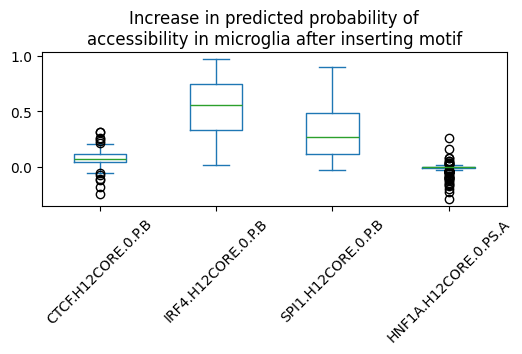

In [14]:
microglia_preds.plot.box(rot=45, figsize=(6,2),
    title='Increase in predicted probability of\naccessibility in microglia after inserting motif')

We can compute the significance of the observed changes using Wilcoxon's signed-rank test:

In [15]:
scipy.stats.wilcoxon(microglia_preds['SPI1.H12CORE.0.P.B'], alternative='greater')

WilcoxonResult(statistic=45138.0, pvalue=3.4306111433259653e-51)

We can also compare the average effect of each motifs across all 204 cell types. For this, we first average the effect across all 500 peaks:

In [14]:
print(preds.shape)
mean_motif_effect = preds.mean(0)
print(mean_motif_effect.shape)

(300, 4, 204)
(4, 204)


This gives us an array of size (motifs x cell types). We can represent this as a pandas dataframe:

In [15]:
mean_motif_effect = pd.DataFrame(mean_motif_effect, index=motif_names, columns=tasks.name)
mean_motif_effect.iloc[:2, :5]

name,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+)
CTCF.H12CORE.0.P.B,0.388244,0.394328,0.432499,0.305751,0.294902
IRF4.H12CORE.0.P.B,-0.036342,-0.012818,0.002286,0.056316,0.036183


For visualization, let us select the 20 cell types with highest variance:

In [16]:
variable_cell_types = mean_motif_effect.var(0).sort_values().tail(20).index
variable_cell_types

Index(['Fetal Photoreceptor', 'Fetal T Lymphocyte 1 (CD4+)',
       'Fetal Enterocyte 3', 'Fetal Enterocyte 1',
       'Fetal Retinal Progenitor 1', 'Memory B', 'Fetal Acinar 2',
       'Macrophage Gen or Alv', 'Hepatocyte', 'Plasma B',
       'Fetal Adrenal Neuron', 'Alpha 1', 'Fetal Adrenal Cortical', 'Acinar',
       'Fetal Thymocyte', 'Macrophage General',
       'Fetal Syncitio+Cytotrophoblast', 'Fetal B Lymphocyte 1 (SPIB+)',
       'Fetal Erythroblast 2', 'Fetal Hepatoblast'],
      dtype='object', name='name')

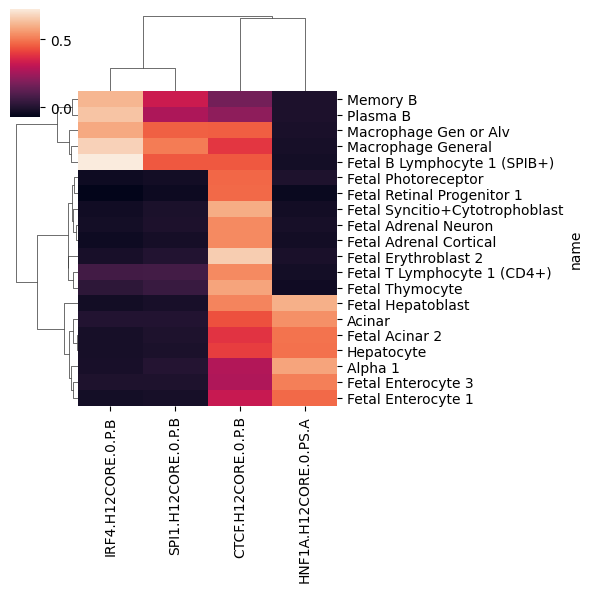

In [17]:
sns.clustermap(mean_motif_effect.loc[:, variable_cell_types].T, figsize=(6,6))

### 1.2 Motif spacing

Given two motifs, we may want to know whether the spacing between them is important for regulatory function. Here, we insert a TEAD motif in the center of the shuffled peak and then insert a FOS motif at different distances from the TEAD motif. We compute the increase in predictions in fibroblasts before and after inserting the TEAD motif. We marginalize the effect of the FOS motif across all 500 shuffled peak sequences.

First, we load the motifs from the HOCOMOCO database:

In [18]:
motifs = grelu.io.motifs.read_meme_file(
    "hocomoco_v12", names=['TEAD1.H12CORE.0.PSM.A', 'FOS.H12CORE.0.P.B']
)

And extract the consensus sequence for each motif:

In [19]:
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)
tead_pattern, fos_pattern = patterns

In [20]:
print(tead_pattern)
print(fos_pattern)

CCACATTCCAGGC
GTGAGTCACCA


gReLU provides another handy function `marginalize_pattern_spacing` to compute the effect of different inter-motif distances. This function produces two outputs: `preds` (model predictions) and `distances` (distances at which the second motif was inserted). Note that distances are calculated between the start positions of the two motifs.

In [21]:
preds, distances = grelu.interpret.simulate.marginalize_pattern_spacing(
    model = catlas,
    seqs = test_intervals,
    fixed_pattern = tead_pattern, # this motif will be fixed at the center of the sequence
    variable_pattern = fos_pattern, # this motif will be inserted at different distances
    genome = 'hg38',
    n_shuffles = 1, # Each test sequence will be shuffled once
    seed = 0,
    devices = 0,
    num_workers = 16,
    batch_size = 512,
    compare_func = 'subtract', # Return the difference in prediction after inserting FOS
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████| 33/33 [00:01<00:00, 25.80it/s]


Note that this produces two outputs: `preds` (the model's predictions) and `distances` (the distance between the two motifs, corresponding to the predictions.

In [22]:
preds = preds.squeeze()
preds.shape

(100, 167, 204)

`preds` has shape `(number of sequences, number of positions, number of tasks)`. We are going to focus on one cell type (fibroblasts). So we subset the predictions for that cell type:

In [23]:
preds = preds[:, :, tasks.name=='Fibro General'].squeeze()
preds.shape

(100, 167)

Let's also take a look at `distances`:

In [24]:
distances[:5]

[-93, -92, -91, -90, -89]

A convenient way to analyze these is to plot predicted effect of the FOS motif vs. distance from the TEAD motif.

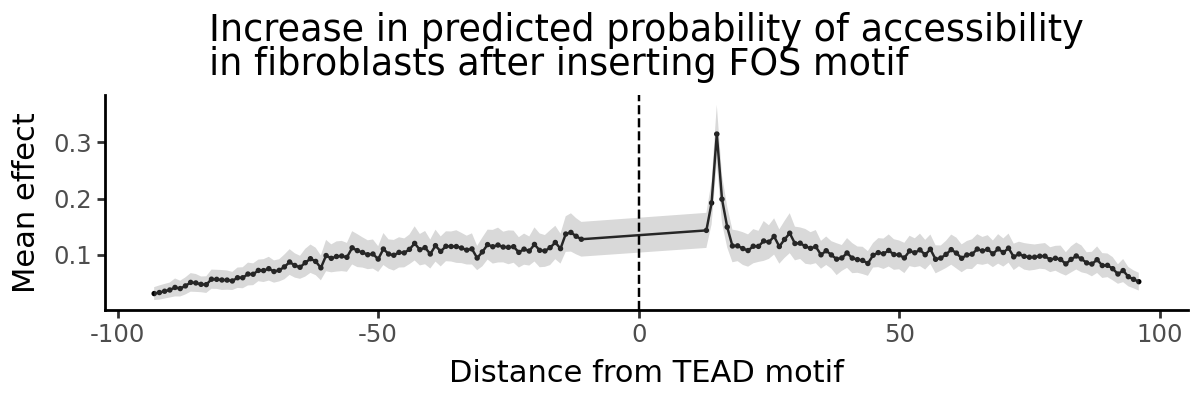

In [25]:
import grelu.visualize
grelu.visualize.plot_position_effect(
    preds, distances,
    title="Increase in predicted probability of accessibility\nin fibroblasts after inserting FOS motif",
    xlab="Distance from TEAD motif",
    figsize=(6,2)
)

In [26]:
pd.DataFrame({'mean_effect':preds.mean(0), 'dist':distances}).sort_values('mean_effect', ascending=False).head()

,mean_effect,dist
85,0.314874,15
86,0.199125,16
84,0.192450,14
87,0.149549,17
83,0.143676,13


gReLU shows us a clear distance dependence: a distance of 15 nucleotides between the start positions of the two motifs creates a composite motif that drives higher predicted accessibility. Since the TEAD motif is 15 bp long, this means two nucleotides between the end of the TEAD motif and the start of the FOS motif (CCACATTCCAGGC _ _ GTGAGTCACCA)

In [27]:
del catlas

## Part 2: Enformer

Next we will examine regulatory relationships between gene TSSs and their genomic context using the Enformer model.

First, we import the Enformer model from the model zoo.

In [28]:
import grelu.resources
enformer = grelu.resources.load_model(
    project="enformer",
    model_name="human",
)

This object includes the task metadata. For the current analyses, we will focus on  a single CAGE track in K562 cells, which is track 5111.

In [29]:
k562_cage_track_idx=5111
tasks = pd.DataFrame(enformer.data_params['tasks'])
tasks.iloc[[k562_cage_track_idx]]

,name,file,clip,scale,sum_stat,description,assay,sample
5111,CNhs12336,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:chronic myelogenous leukemia cell line:K5...,CAGE,chronic myelogenous leukemia cell line:K562 EN...


We are going to analyze CAGE activity at the TSS of the ABCA8 gene. This gene is located on chromosome 17 and its TSS is at position 68955392. We define a region of 5000 bp centered on this position as the TSS region.

In [30]:
tss_interval = pd.DataFrame({
    'chrom':['chr17'], 'start':[68955392-2500], 'end':[68955392+2500]
})
print(tss_interval)

   chrom     start       end
0  chr17  68952892  68957892


And extract its sequence from the genome:

In [31]:
import grelu.sequence.format
tss_seq = grelu.sequence.format.convert_input_type(tss_interval, "strings", genome="hg38")[0] # Don't try to print this!

We will construct an input interval for Enformer centered on this TSS position.

In [32]:
import grelu.sequence.utils
input_interval = grelu.sequence.utils.resize(tss_interval, enformer.data_params['train']['seq_len'])
input_interval

,chrom,start,end
0,chr17,68857088,69053696


Let's examine Enformer's predictions for this interval:

In [33]:
input_seq = grelu.sequence.format.convert_input_type(input_interval, "strings", genome='hg38')[0]
input_pred = enformer.predict_on_seqs(input_seq, device=0)
input_pred.shape

(1, 5313, 896)

Enformer predicts 5313 output tracks, but we are only interested in the predictions for the K562 CAGE track - let's plot those, and highlight the TSS region that we defined.

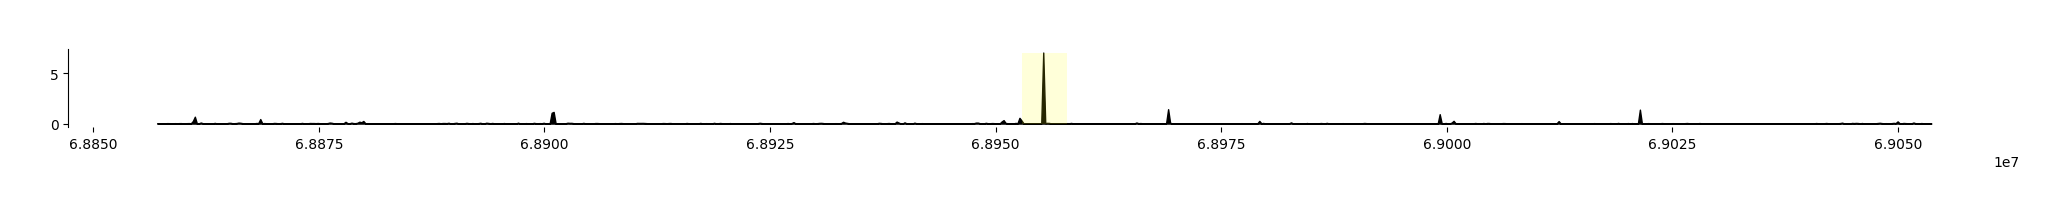

In [34]:
fig = grelu.visualize.plot_tracks(
    input_pred[:, k562_cage_track_idx],
    start_pos=input_interval.start[0], end_pos=input_interval.end[0],
    highlight_intervals=tss_interval,
)

We see that Enformer predicts transcriptional activity at the ABCA8 TSS.

Instead of making predictions for the entire sequence across all tracks and then subsetting the TSS and the K562 CAGE track each time, gReLU allows us to use a transform object that will compute only the relevant predictions. 

Here, we can create an `Aggregate` transform that sums the predicted values in the bins overlapping the TSS region, in the K562 CAGE track. This transform, when applied to Enformer's predictions, computes the statistic we're interested in.

To do this, we first need the indices of the output bins that overlap with the TSS region:

In [35]:
enformer.input_intervals_to_output_bins(tss_interval, start_pos=input_interval.start[0])

,start,end
0,428,468


Now we can create the transform:

In [36]:
from grelu.transforms.prediction_transforms import Aggregate
tss_activity_transform = Aggregate(
    tasks=k562_cage_track_idx,
    positions=list(range(428, 468)), # these are the indices of the central bins overlapping with the TSS
    length_aggfunc='sum' # Sum the output over all bins
)

So we can now compute the TSS activity in the wild-type sequence:

In [37]:
WT = tss_activity_transform.compute(input_pred).squeeze()
WT

array(9.031218, dtype=float32)

Next, we will simulate different changes to this locus and see how this statistic changes.

### 2.1 Context dependence test

The context dependence test introduced in CREME (https://doi.org/10.1101/2023.07.03.547592) measures the extent to which a prediction of a given TSS activity is influenced by its context.

It includes the following steps:

- Predict TSS activity for the wild type sequence (denoted as WT).
- Dinucleotide shuffle the sequence (except the 5kb tile centered at the TSS).
- Predict TSS activity for the shuffled sequence (denoted as MUTANT).
- Normalization: compute context effect on TSS using WT as control: (WT - MUTANT) / WT
- Repeat steps 2-4 10 times and average across different random dinucleotide shuffles.

A positive effect size means that the central TSS prediction for the mutated sequence is lower than WT, which indicates that we have perturbed an enhancing context. Negative effect size means that the central TSS prediction for the mutated sequence is higher than WT, which suggests that we have perturbed a silencing context.

We have already done the first step, which is to predict TSS activity in the wild-type (WT). So, we move on to the subsequent steps.

Using gReLU, we can shuffle the input sequence 10 times.

In [38]:
shuffled_seqs = grelu.sequence.utils.dinuc_shuffle(input_seq, n_shuffles=10, seed=0)

And re-insert the TSS region into the center of the shuffled sequences:

In [39]:
from grelu.sequence.mutate import mutate
shuf_seqs_w_tss = [mutate(s, tss_seq) for s in shuffled_seqs]

We now make predictions for the TSS in the shuffled sequences:

In [40]:
from grelu.data.dataset import SeqDataset
ds = SeqDataset(shuf_seqs_w_tss)

# Make predictions
MUTANT = enformer.predict_on_dataset(ds, devices=0, batch_size=8)

# Apply the transform to compute predicted TSS activity
MUTANT = tss_activity_transform.compute(MUTANT).squeeze()

MUTANT

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.49it/s]


array([1.7114824, 1.794982 , 1.6819102, 1.7479782, 1.6679873, 1.626009 ,
       1.6097338, 1.7588503, 1.6144758, 1.6506245], dtype=float32)

And compute the final metric:

In [41]:
result = np.mean((WT - MUTANT) / WT)
result

0.8132695

The positive value shows that the TSS is in an enhancing context.

### 2.2 Enhancer Discovery by in silico tiling
Which parts of the input sequence are responsible for its enhancing context? We can discover putative regulatory elements in silico by shuffling successive tiles in the sequence and computing the change in predicted TSS activity. gReLU provides a shuffle_tiles function for this analysis:

Which parts of the input sequence are responsible for its enhancing context? We can discover putative regulatory elements <i>in silico</i> by shuffling successive tiles in the sequence and computing the change in predicted TSS activity. gReLU provides a `shuffle_tiles` function for this analysis:

In [42]:
preds, tiles = grelu.interpret.simulate.shuffle_tiles(
    model=enformer,
    seqs=[input_seq],
    tile_len=5000, # Length of region to shuffle
    stride=2500, # Tiles will overlap by this much
    protect_center= 5000, # Do not disrupt the central TSS region
    n_shuffles = 5, # Number of times to shuffle each tile
    seed = 0,
    devices=0,
    num_workers=16,
    batch_size=8,
    prediction_transform=tss_activity_transform,
    compare_func='subtract',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████| 46/46 [00:25<00:00,  1.82it/s]


Note that this produces two outputs: `preds` (the model's predictions) and `tiles` (the regions that were shuffled, corresponding to the predictions).

In [43]:
print(tiles.shape)
tiles.head()

(73, 2)


,start,end
0,0,5000
1,2500,7500
2,5000,10000
3,7500,12500
4,10000,15000


In [44]:
preds = preds.squeeze()
preds.shape

(73, 5)

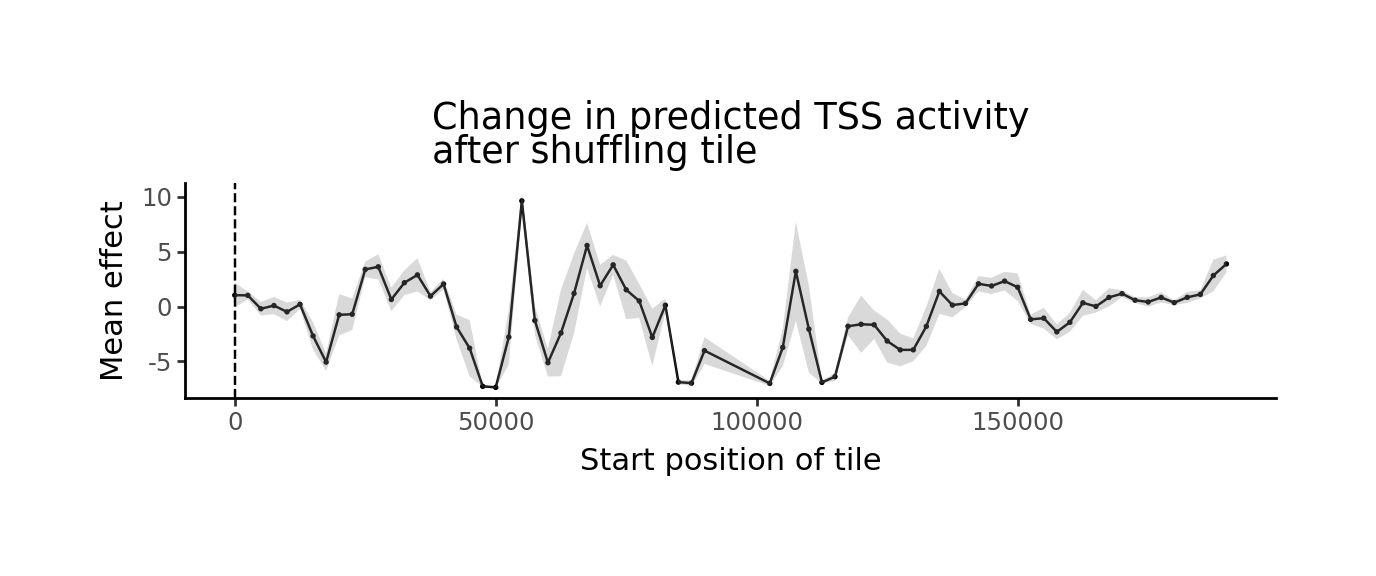

In [45]:
grelu.visualize.plot_position_effect(
    preds.T, tiles.start.tolist(),
    title="Change in predicted TSS activity\nafter shuffling tile",
    xlab="Start position of tile",
    figsize=(6,2)
)

The tiles with the strongest negative value are the putative enhancers. For a tabular representation, we can add the predictions to the dataframe, averaging across all shuffles of the same sequence, then sort the tiles by effect:

In [46]:
tiles['effect'] = preds.mean(1)

In [47]:
tiles.sort_values('effect').head(3)

,start,end,effect
20,50000,55000,-7.360337
19,47500,52500,-7.263155
37,102500,107500,-6.995717


It seems that the tile from position 50,000 - 55,000 of the input sequence has the strongest enhancer activity. We will define this as our putative CRE and extract its sequence.

In [48]:
cre_pos = 50000
cre_seq = input_seq[cre_pos: cre_pos+5000]

### 2.3 Sufficiency test

The sufficiency test (also from CREME) consists of the following steps:

1. Predict TSS activity for the wild type sequence (WT).
2. Dinucleotide shuffle the sequence.
3. Add the TSS 5 kb tile and predict TSS activity (CONTROL).
4. Add the CRE and the TSS tiles to the sequence and predict TSS activity (MUTANT).
5. in case of enhancing context sequences, we compute the normalized CRE effect as (MUTANT - CONTROL) / WT.
7. Repeat each shuffle 10 times and average the normalized CRE effect per sequence.

We insert the CRE into our 10 shuffled sequences containing the TSS.

In [49]:
shuffled_seqs_w_tss_and_cre = [mutate(s, cre_seq, pos=cre_pos) for s in shuf_seqs_w_tss]

Note that what was previously called MUTANT (shuffled sequence with the TSS tile) is now called CONTROL, so we rename it:

In [50]:
CONTROL = MUTANT
del MUTANT

And then make predictions:

In [51]:
ds = SeqDataset(shuffled_seqs_w_tss_and_cre)
MUTANT = enformer.predict_on_dataset(ds, devices=0, batch_size=8).squeeze()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.49it/s]


In [52]:
MUTANT = tss_activity_transform.compute(MUTANT)

In [53]:
results = np.mean((MUTANT - CONTROL) / WT)
results

0.028892074

This suggests that although shuffling the CRE has a large effect on TSS activity, it is not sufficient to increase TSS activity much on its own.

### 2.4 TSS-CRE Distance Test

CREME defined a 'TSS-CRE Distance test' in which the TSS is inserted into a dinucleotide-shuffled sequence, the putative CRE is inserted at different distances from the TSS, and its effect is measured at each distance. We can do a similar experiment using the previously seen `marginalize_pattern_spacing` function.

In [54]:
preds, distances = grelu.interpret.simulate.marginalize_pattern_spacing(
    model = enformer,
    seqs = input_seq,
    fixed_pattern = tss_seq, # The TSS will be fixed in the center of the sequence
    variable_pattern = cre_seq, # The CRE will be inserted at different distances
    stride=5000, # The CRE insertion position will shift by 5000 bp
    n_shuffles = 10, # The input sequence will be shuffled 10 times and results averaged
    seed = 0,
    devices=0,
    num_workers=16,
    batch_size=8,
    prediction_transform=tss_activity_transform,
    compare_func='subtract', # Compute the fold change of prediction after inserting the CRE
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████| 48/48 [00:26<00:00,  1.81it/s]


In [55]:
preds = preds.squeeze()
preds.shape

(10, 37)

In [56]:
len(distances)

37

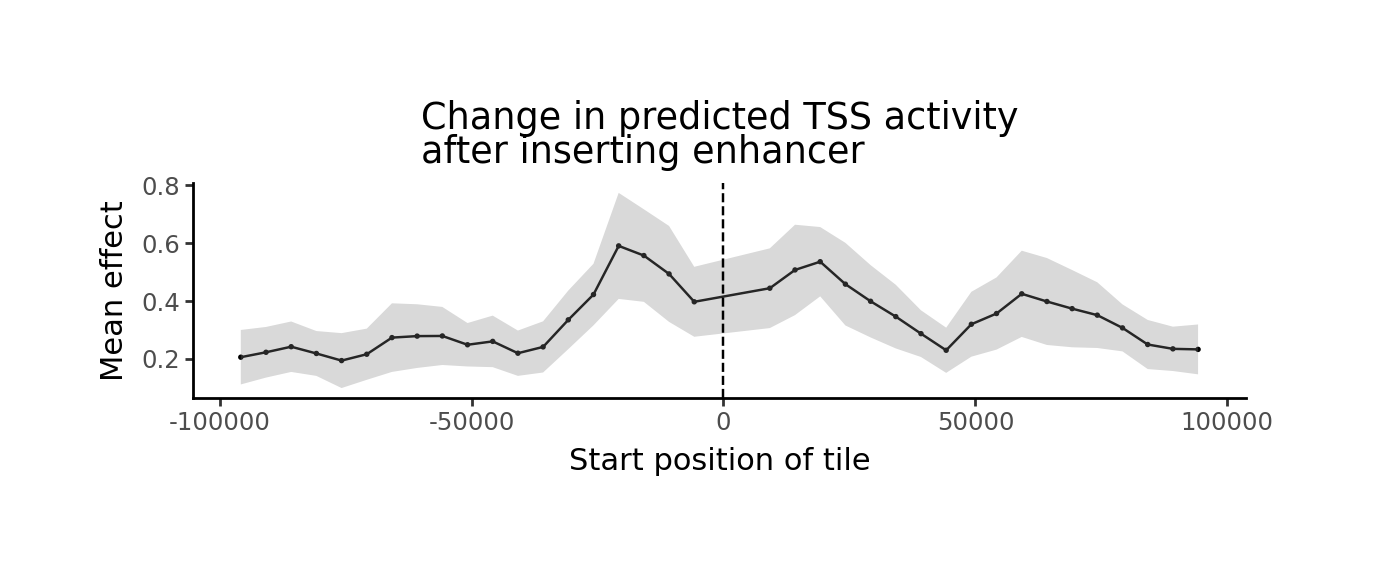

In [60]:
grelu.visualize.plot_position_effect(
    preds, distances,
    title="Change in predicted TSS activity\nafter inserting enhancer",
    xlab="Start position of tile",
    figsize=(6,2)
)

In [61]:
df = pd.DataFrame({'distance':distances, 'effect': preds.mean(0)})
df.sort_values('effect', ascending=False).head()

,distance,effect
15,-20804,0.591094
16,-15804,0.557633
21,19196,0.536396
20,14196,0.507965
17,-10804,0.494132
